In [8]:
import warnings

warnings.filterwarnings('ignore')

In [9]:
import pandas as pd
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# ---------------------------------------------------------
# 1. 환경변수 로드 (notebooks 폴더의 상위 폴더에 있는 .env 로드)
# ---------------------------------------------------------
load_dotenv(dotenv_path="../.env")

# 2. DB 연결
DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": int(os.getenv("DB_PORT", 3306)),
    "user": os.getenv("DB_USER", "admin"),
    "password": os.getenv("DB_PASSWORD"),
    "db": os.getenv("DB_NAME", "projectl")
}

db_url = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['db']}"
engine = create_engine(db_url)
print("✅ DB 연결 성공!")

# ---------------------------------------------------------
# 3. 데이터 수집 함수 (스키마 컬럼명 수정 완료)
# ---------------------------------------------------------
def get_item_data(item_name):
    conn = engine.connect()
    try:
        # (1) 아이템 ID 찾기
        item_sql = text("SELECT id FROM market_items WHERE name = :name")
        item_id = conn.execute(item_sql, {"name": item_name}).scalar()
        
        if not item_id:
            print(f"❌ '{item_name}' 아이템을 찾을 수 없습니다.")
            return None, None

        print(f"🔍 '{item_name}' (ID: {item_id}) 데이터 수집 중...")

        # (2) 가격 로그 가져오기 (컬럼명: current_min_price, logged_at)
        price_sql = text("""
            SELECT logged_at, current_min_price
            FROM market_price_logs
            WHERE item_id = :item_id
            ORDER BY logged_at ASC
        """)
        df_prices = pd.read_sql(price_sql, conn, params={"item_id": item_id})
        
        # (3) GPT Score 가져오기 (컬럼명: notice_date, gpt_score)
        notice_sql = text("""
            SELECT r.notice_date, i.gpt_score
            FROM item_notice_impacts i
            JOIN raw_notices r ON i.notice_id = r.id
            WHERE i.item_id = :item_id
            ORDER BY r.notice_date ASC
        """)
        df_notices = pd.read_sql(notice_sql, conn, params={"item_id": item_id})
        
        print(f"   - 가격 로그: {len(df_prices)}개")
        print(f"   - 관련 공지: {len(df_notices)}개")
        
        return df_prices, df_notices

    finally:
        conn.close()

# ---------------------------------------------------------
# [테스트] 아이템 이름 입력
# ---------------------------------------------------------
TARGET_ITEM = "유물 원한 각인서"  # 👈 분석하고 싶은 아이템 이름
df_raw, df_gpt = get_item_data(TARGET_ITEM)

display(df_raw.head())
display(df_gpt.head())

✅ DB 연결 성공!
🔍 '유물 원한 각인서' (ID: 65200505) 데이터 수집 중...
   - 가격 로그: 7472개
   - 관련 공지: 8개


,logged_at,current_min_price
0,2025-12-18 11:00:22.041111,178699
1,2025-12-18 11:10:59.700297,177998
2,2025-12-18 11:21:36.873504,178800
3,2025-12-18 11:32:12.909622,178000
4,2025-12-18 11:42:48.640077,178000


,notice_date,gpt_score
0,2025-12-17,0.0
1,2025-12-24,0.0
2,2025-12-31,0.0
3,2026-01-07,0.3
4,2026-01-14,0.0


In [10]:
from datetime import timedelta

# =========================================================
# 함수 1: 가격 데이터 정제 (구멍 메우기 + OHLC)
# =========================================================
def preprocess_ohlc_and_fill(df_raw):
    print("🧹 [1단계] 가격 데이터 정제 및 시간 구멍 메우기...")
    
    df = df_raw.copy()
    
    # 1. 인덱스 설정
    if 'logged_at' in df.columns:
        df['logged_at'] = pd.to_datetime(df['logged_at'])
        df.set_index('logged_at', inplace=True)
    
    # 2. 30분 단위 Resampling
    df_resampled = df['current_min_price'].resample('30min').agg(['first', 'max', 'min', 'last', 'mean'])
    df_resampled.columns = ['Open', 'High', 'Low', 'Close', 'Price_Mean']
    
    # 3. 빈칸 채우기 (Forward Fill -> Backward Fill)
    df_filled = df_resampled.ffill().bfill()
    
    print(f"   - 정제 완료: {len(df_filled)}개 구간")
    return df_filled

# =========================================================
# 함수 2: GPT 스코어 매핑 (날짜 계산 로직)
# =========================================================
def apply_gpt_scores(df_price, df_gpt):
    print("🤖 [2단계] GPT 공지사항 점수 매핑 중...")
    
    df = df_price.copy()
    df['GPT_Score'] = 0.0 # 기본값 0
    
    if df_gpt is None or df_gpt.empty:
        print("   - 공지사항 데이터가 없습니다. (점수 0으로 진행)")
        return df

    count = 0
    for idx, row in df_gpt.iterrows():
        notice_date = pd.to_datetime(row['notice_date'])
        score = row['gpt_score']
        
        # [규칙 적용] 공지일 10:00 ~ 7일 뒤 06:00
        start_time = notice_date.replace(hour=10, minute=0, second=0)
        end_time = (notice_date + timedelta(days=7)).replace(hour=6, minute=0, second=0)
        
        # 해당 기간 마스킹
        mask = (df.index >= start_time) & (df.index < end_time)
        
        if mask.any():
            df.loc[mask, 'GPT_Score'] = score
            count += 1
            
    print(f"   - 총 {count}건의 공지사항 점수 반영 완료")
    return df

# =========================================================
# [실행] 두 함수 연결해서 최종 데이터 만들기
# =========================================================

# 1. 가격 데이터 정제
df_clean_price = preprocess_ohlc_and_fill(df_raw)

# 2. GPT 점수 결합
df_final = apply_gpt_scores(df_clean_price, df_gpt)

# 3. 결과 확인
print("-" * 30)
print(f"🗓️ 데이터 기간: {df_final.index.min()} ~ {df_final.index.max()}")
print("-" * 30)
display(df_final.tail()) # 최근 데이터 확인

🧹 [1단계] 가격 데이터 정제 및 시간 구멍 메우기...
   - 정제 완료: 2589개 구간
🤖 [2단계] GPT 공지사항 점수 매핑 중...
   - 총 8건의 공지사항 점수 반영 완료
------------------------------
🗓️ 데이터 기간: 2025-12-18 11:00:00 ~ 2026-02-10 09:00:00
------------------------------


,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-10 07:00:00,149900.0,150000.0,149900.0,150000.0,149966.666667,0.0
2026-02-10 07:30:00,153399.0,153400.0,153399.0,153400.0,153399.333333,0.0
2026-02-10 08:00:00,153400.0,153400.0,152000.0,152000.0,152866.666667,0.0
2026-02-10 08:30:00,152000.0,152000.0,152000.0,152000.0,152000.000000,0.0
2026-02-10 09:00:00,151999.0,151999.0,151800.0,151800.0,151899.333333,0.0


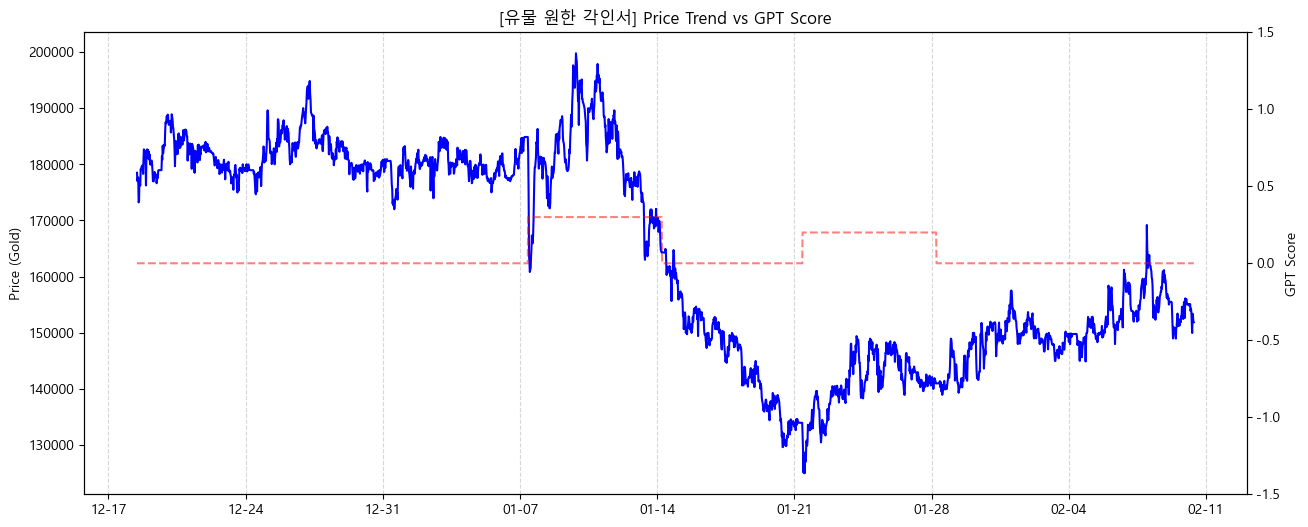

,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-10 07:00:00,149900.0,150000.0,149900.0,150000.0,149966.666667,0.0
2026-02-10 07:30:00,153399.0,153400.0,153399.0,153400.0,153399.333333,0.0
2026-02-10 08:00:00,153400.0,153400.0,152000.0,152000.0,152866.666667,0.0
2026-02-10 08:30:00,152000.0,152000.0,152000.0,152000.0,152000.000000,0.0
2026-02-10 09:00:00,151999.0,151999.0,151800.0,151800.0,151899.333333,0.0


In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 3. 시각화 (확인용)
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))

# 가격 그래프 (파란색)
ax1 = plt.gca()
ax1.plot(df_final.index, df_final['Price_Mean'], color='blue', label='Avg Price')
ax1.set_ylabel('Price (Gold)')

# GPT 점수 그래프 (빨간색, y축 공유)
ax2 = ax1.twinx()
ax2.plot(df_final.index, df_final['GPT_Score'], color='red', linestyle='--', alpha=0.5, label='GPT Score')
ax2.set_ylabel('GPT Score')
ax2.set_ylim(-1.5, 1.5)

# 2. 눈금 형식: '월-일' 형태로 보여줘라 (예: 01-29)
# 연도까지 보고 싶으면 '%Y-%m-%d'로 바꾸시면 됩니다.
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.grid(True, which='major', axis='x', linestyle='--', alpha=0.5) # 수요일마다 세로 점선 추가

plt.title(f"[{TARGET_ITEM}] Price Trend vs GPT Score")
plt.show()

# 데이터 확인
display(df_final.tail())

In [12]:
import numpy as np

# 1. 원본 복사
df_ml = df_final.copy()

# ---------------------------------------------------------
# 2. 기술적 지표 (이동평균, 변동성, RSI)
# ---------------------------------------------------------
# 가격의 흐름(Trend)을 모델에게 알려줍니다.
df_ml['MA_5'] = df_ml['Close'].rolling(window=5).mean()    # 2.5시간 평균
df_ml['MA_48'] = df_ml['Close'].rolling(window=48).mean()  # 24시간(1일) 평균
df_ml['Std_20'] = df_ml['Close'].rolling(window=20).std()  # 변동성

# RSI (상대강도지수)
delta = df_ml['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df_ml['RSI'] = 100 - (100 / (1 + rs))

# ---------------------------------------------------------
# 3. [핵심] Lag Features (시차 데이터)
# ---------------------------------------------------------
# 모델 학습용으로 "과거의 정답"을 미리 만들어두는 겁니다.
# (나중에 예측할 때는 이 컬럼을 우리가 직접 채워넣으며 예측해야 합니다)
df_ml['Close_Lag1'] = df_ml['Close'].shift(1)  # 30분 전
df_ml['Close_Lag2'] = df_ml['Close'].shift(2)  # 1시간 전
df_ml['GPT_Lag1'] = df_ml['GPT_Score'].shift(1) # 30분 전 공지 점수

# ---------------------------------------------------------
# 4. 시간 정보 (Time Features)
# ---------------------------------------------------------
# 미래의 시간(요일, 시간)은 우리가 달력만 보면 100% 알 수 있으므로 아주 좋은 힌트입니다.
df_ml['Hour'] = df_ml.index.hour
df_ml['DayOfWeek'] = df_ml.index.dayofweek # 0:월 ~ 6:일

# ---------------------------------------------------------
# 5. Target (정답지: 다음 30분 뒤의 가격)
# ---------------------------------------------------------
df_ml['Target'] = df_ml['Close'].shift(-1)

# 결측치 제거 (이동평균 등으로 생긴 앞부분 빈칸 삭제)
df_ml = df_ml.dropna()

print(f"📚 머신러닝 데이터 준비 완료: {df_ml.shape}")
display(df_ml.tail())

📚 머신러닝 데이터 준비 완료: (2541, 16)


,Open,High,Low,Close,Price_Mean,GPT_Score,MA_5,MA_48,Std_20,RSI,Close_Lag1,Close_Lag2,GPT_Lag1,Hour,DayOfWeek,Target
logged_at,,,,,,,,,,,,,,,,
2026-02-10 06:30:00,153399.0,153399.0,149900.0,149900.0,151840.333333,0.0,153468.0,153121.000000,1325.092190,13.913867,153443.0,154000.0,0.0,6,1,150000.0
2026-02-10 07:00:00,149900.0,150000.0,149900.0,150000.0,149966.666667,0.0,152468.2,153141.833333,1706.674466,14.920486,149900.0,153443.0,0.0,7,1,153400.0
2026-02-10 07:30:00,153399.0,153400.0,153399.0,153400.0,153399.333333,0.0,152148.6,153233.520833,1709.609173,43.897860,150000.0,149900.0,0.0,7,1,152000.0
2026-02-10 08:00:00,153400.0,153400.0,152000.0,152000.0,152866.666667,0.0,151748.6,153254.375000,1790.029465,35.592036,153400.0,150000.0,0.0,8,1,152000.0
2026-02-10 08:30:00,152000.0,152000.0,152000.0,152000.0,152000.000000,0.0,151460.0,153275.208333,1790.766731,37.216947,152000.0,153400.0,0.0,8,1,151800.0


📊 LSTM 데이터셋 준비 중...
📚 학습 데이터 형태: (2247, 1, 9)
📝 검증 데이터 형태: (294, 1, 9)

🧠 LSTM 학습 시작... (GPU: OFF)
✅ LSTM 학습 완료!

💯 [LSTM 성적표 - 검증 데이터 기준]
   - RMSE: ±2923.27 골드
   - MAE : ±2295.44 골드


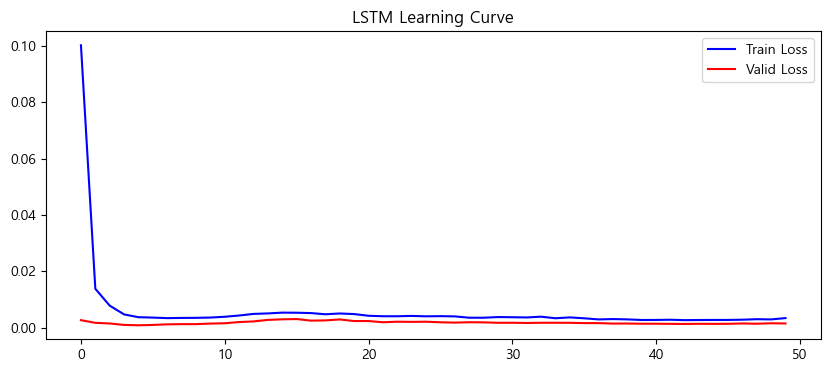


🔮 LSTM으로 미래 3일 예측 중... (스케일링 주의)
✅ 예측 완료!


,날짜,예측가격
0,2026-02-10 09:00:00,150613.281250
1,2026-02-10 09:30:00,150050.859375
2,2026-02-10 10:00:00,149702.343750
3,2026-02-10 10:30:00,149493.859375
4,2026-02-10 11:00:00,149395.265625


,날짜,예측가격
139,2026-02-13 06:30:00,149023.109375
140,2026-02-13 07:00:00,149006.250000
141,2026-02-13 07:30:00,148936.921875
142,2026-02-13 08:00:00,148920.234375
143,2026-02-13 08:30:00,148852.703125


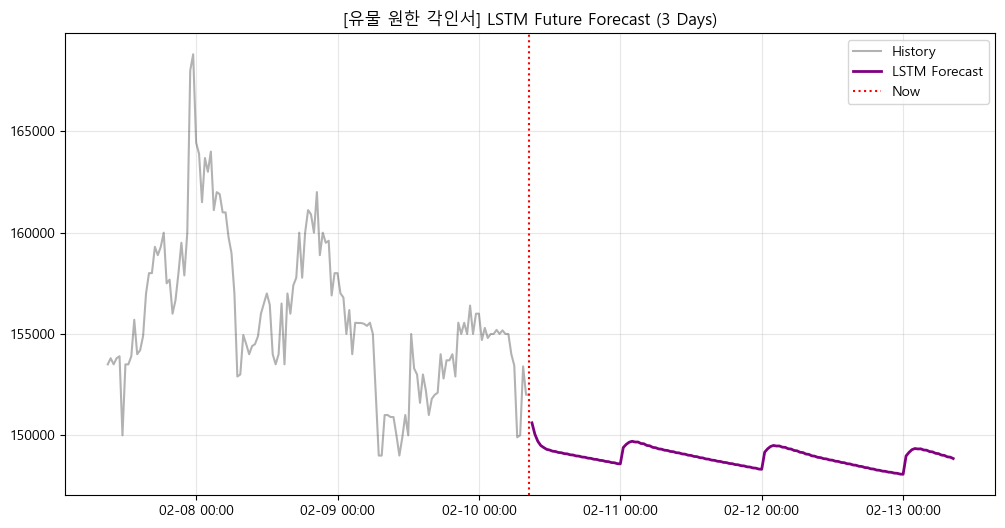


📊 [LSTM 3일 뒤 예측] 148853 G


In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------------------------------------------------------
# 1. 데이터 준비 & 스케일링 (LSTM 필수!)
# ---------------------------------------------------------
print("📊 LSTM 데이터셋 준비 중...")

# 사용할 피처 (XGB/LGBM과 동일)
features = [
    'MA_5', 'MA_48', 'Std_20', 'RSI',
    'Close_Lag1', 'Close_Lag2', 'GPT_Lag1',
    'Hour', 'DayOfWeek'
]
target = 'Target'

# [중요] 학습 데이터 기준일 (2월 4일 06:00) 고정
train_cutoff = pd.to_datetime("2026-02-04 06:00:00")

# 1) 스케일링 (0~1 사이로 압축) - 딥러닝은 큰 숫자를 싫어합니다.
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# 전체 데이터 스케일링
X_scaled = scaler_X.fit_transform(df_ml[features])
y_scaled = scaler_y.fit_transform(df_ml[[target]])

# DataFrame으로 변환 (인덱스 유지)
X_scaled_df = pd.DataFrame(X_scaled, columns=features, index=df_ml.index)
y_scaled_df = pd.DataFrame(y_scaled, columns=[target], index=df_ml.index)

# 2) 학습/검증 데이터 분리 (Cutoff 기준)
X_train = X_scaled_df[X_scaled_df.index < train_cutoff]
y_train = y_scaled_df[y_scaled_df.index < train_cutoff]

X_valid = X_scaled_df[X_scaled_df.index >= train_cutoff]
y_valid = y_scaled_df[y_scaled_df.index >= train_cutoff]

# 3) 3차원 변환 (Samples, Timesteps, Features)
# LSTM은 입력을 3차원으로 받습니다. (여기선 Timestep=1로 설정)
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_lstm = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

print(f"📚 학습 데이터 형태: {X_train_lstm.shape}")
print(f"📝 검증 데이터 형태: {X_valid_lstm.shape}")

# ---------------------------------------------------------
# 2. LSTM 모델 구조 정의 및 학습
# ---------------------------------------------------------
print(f"\n🧠 LSTM 학습 시작... (GPU: {'ON' if tf.config.list_physical_devices('GPU') else 'OFF'})")

model_lstm = Sequential()

# LSTM 레이어 (복잡한 패턴 기억)
model_lstm.add(LSTM(64, input_shape=(1, len(features)), return_sequences=False))
model_lstm.add(Dropout(0.2)) # 과적합 방지 (일부러 20% 깜빡하게 만듦)
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(1)) # 가격 1개 예측

model_lstm.compile(loss='mse', optimizer='adam')

# 학습 실행
history = model_lstm.fit(
    X_train_lstm, y_train,
    epochs=50,           # 공부 횟수 (너무 많으면 과적합)
    batch_size=32,       # 한 번에 볼 문제집 양
    validation_data=(X_valid_lstm, y_valid),
    verbose=0,           # 로그 끄기 (깔끔하게)
    shuffle=False        # [주의] 시계열 데이터는 절대 섞으면 안 됨!
)
print("✅ LSTM 학습 완료!")

# ---------------------------------------------------------
# 3. 검증 데이터 평가 (성적표)
# ---------------------------------------------------------
# 예측 (0~1 스케일 상태)
valid_preds_scaled = model_lstm.predict(X_valid_lstm, verbose=0)

# 원상복구 (Inverse Transform)
valid_preds_real = scaler_y.inverse_transform(valid_preds_scaled)
y_valid_real = scaler_y.inverse_transform(y_valid)

# 점수 계산
rmse_lstm = np.sqrt(mean_squared_error(y_valid_real, valid_preds_real))
mae_lstm = mean_absolute_error(y_valid_real, valid_preds_real)

print(f"\n💯 [LSTM 성적표 - 검증 데이터 기준]")
print(f"   - RMSE: ±{rmse_lstm:.2f} 골드")
print(f"   - MAE : ±{mae_lstm:.2f} 골드")

# 학습 곡선 시각화
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Valid Loss', color='red')
plt.title('LSTM Learning Curve')
plt.legend()
plt.show()

# ---------------------------------------------------------
# 4. 미래 3일 재귀적 예측 (Recursive Forecasting)
# ---------------------------------------------------------
print(f"\n🔮 LSTM으로 미래 3일 예측 중... (스케일링 주의)")

future_preds_scaled = []
future_dates = []

# 마지막 데이터(현재 시점) 가져오기 - 스케일링 된 상태여야 함!
last_row_scaled = X_scaled_df.iloc[[-1]].copy()
current_time = last_row_scaled.index[0]

# 피처 이름 인덱스 매핑 (업데이트 편의용)
feat_idx = {name: i for i, name in enumerate(features)}

for i in range(144): # 3일치
    # 1. 입력 형태 변환 (1, 1, feature_num)
    input_seq = last_row_scaled.values.reshape((1, 1, len(features)))
    
    # 2. 예측 (0~1 값)
    pred_scaled = model_lstm.predict(input_seq, verbose=0)[0][0]
    
    # 3. 저장
    future_preds_scaled.append(pred_scaled)
    next_time = current_time + pd.Timedelta(minutes=30)
    future_dates.append(next_time)
    
    # 4. 피처 업데이트 (다음 스텝 준비)
    # (1) Lag 밀어내기
    last_row_scaled['Close_Lag2'] = last_row_scaled['Close_Lag1']
    last_row_scaled['Close_Lag1'] = pred_scaled  # 방금 예측한 값 사용
    last_row_scaled['GPT_Lag1'] = 0.0 # 미래 공지 없음 가정
    
    # (2) 시간 정보 업데이트 (주의: 스케일링 필요)
    next_hour = next_time.hour
    next_day = next_time.dayofweek
    
    # 시간 정보를 스케일러에 넣기 위해 임시 배열 생성
    # (다른 값은 중요하지 않고 Hour, Day만 변환하면 됨)
    temp_input = np.zeros((1, len(features)))
    temp_input[0, feat_idx['Hour']] = next_hour
    temp_input[0, feat_idx['DayOfWeek']] = next_day
    
    # 변환
    temp_scaled = scaler_X.transform(temp_input)
    
    # 업데이트
    last_row_scaled['Hour'] = temp_scaled[0, feat_idx['Hour']]
    last_row_scaled['DayOfWeek'] = temp_scaled[0, feat_idx['DayOfWeek']]
    
    current_time = next_time

# 5. 결과 원상복구
future_preds_real = scaler_y.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))

forecast_3days_lstm = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': future_preds_real.flatten()
})

print("✅ 예측 완료!")
display(forecast_3days_lstm.head())
display(forecast_3days_lstm.tail())

# ---------------------------------------------------------
# 5. 최종 시각화
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# 과거 데이터 (최근 3일)
history_view = df_ml.tail(144)
plt.plot(history_view.index, history_view['Close'], label='History', color='black', alpha=0.3)

# LSTM 예측
plt.plot(forecast_3days_lstm['날짜'], forecast_3days_lstm['예측가격'], 
         label='LSTM Forecast', color='purple', linewidth=2)

plt.axvline(df_ml.index[-1], color='red', linestyle=':', label='Now')
plt.title(f"[{TARGET_ITEM}] LSTM Future Forecast (3 Days)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.show()

print(f"\n📊 [LSTM 3일 뒤 예측] {forecast_3days_lstm['예측가격'].iloc[-1]:.0f} G")

---------------------------------------------------------------------------
Model      | RMSE     | MAE      | MAPE (%)   | R2 Score | Dir Acc (%)
---------------------------------------------------------------------------
LSTM       | 2923.27    | 2295.44    | 1.47%      | 0.4852   | 41.3%
---------------------------------------------------------------------------


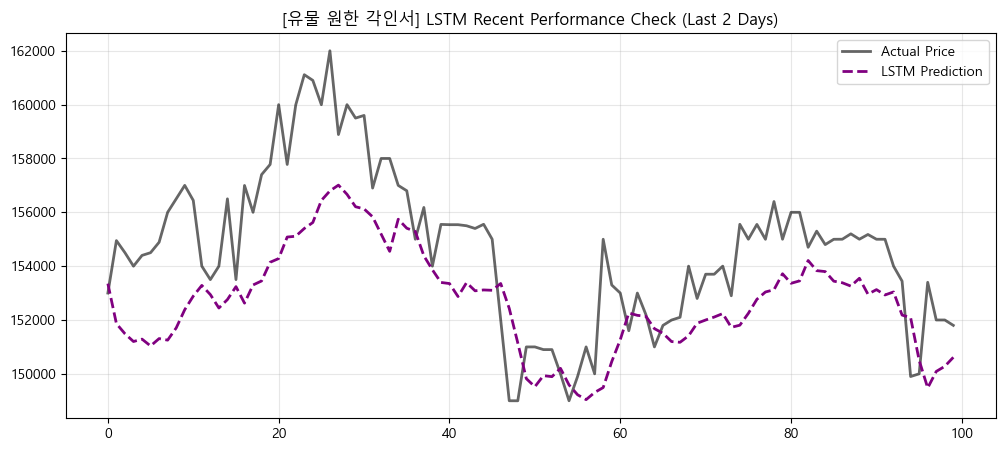

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ---------------------------------------------------------
# 1. 예측값 원상복구 (이미 위에서 했다면 생략 가능하지만 안전하게 다시)
# ---------------------------------------------------------
# LSTM은 0~1 사이로 예측했으므로, 실제 가격(골드)으로 변환해야 채점이 가능합니다.
valid_preds_scaled = model_lstm.predict(X_valid_lstm, verbose=0)

valid_preds_real = scaler_y.inverse_transform(valid_preds_scaled).flatten()
y_valid_real = scaler_y.inverse_transform(y_valid).flatten()

# ---------------------------------------------------------
# 2. 5대 지표 계산 (Machine Learning 모델과 동일 기준)
# ---------------------------------------------------------

# (1) RMSE & MAE
rmse = np.sqrt(mean_squared_error(y_valid_real, valid_preds_real))
mae = mean_absolute_error(y_valid_real, valid_preds_real)

# (2) MAPE (퍼센트 오차)
mape = np.mean(np.abs((y_valid_real - valid_preds_real) / (y_valid_real + 1e-7))) * 100

# (3) R2 Score (설명력)
r2 = r2_score(y_valid_real, valid_preds_real)

# (4) Direction Accuracy (방향 정확도)
true_diff = np.diff(y_valid_real)
pred_diff = np.diff(valid_preds_real)
# 방향이 같으면 정답 (부호가 같음)
correct_direction = np.sum(np.sign(true_diff) == np.sign(pred_diff))
dir_acc = (correct_direction / len(true_diff)) * 100

# ---------------------------------------------------------
# 3. 성적표 출력
# ---------------------------------------------------------
print("-" * 75)
print(f"{'Model':<10} | {'RMSE':<8} | {'MAE':<8} | {'MAPE (%)':<10} | {'R2 Score':<8} | {'Dir Acc (%)':<10}")
print("-" * 75)
print(f"{'LSTM':<10} | {rmse:.2f}    | {mae:.2f}    | {mape:.2f}%      | {r2:.4f}   | {dir_acc:.1f}%")
print("-" * 75)

# ---------------------------------------------------------
# 4. (보너스) 실제 vs 예측 그래프 확대
# ---------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
# 전체 말고 최근 100개(약 2일치)만 확대해서 봅니다.
limit = 100
plt.plot(y_valid_real[-limit:], label='Actual Price', color='black', alpha=0.6, linewidth=2)
plt.plot(valid_preds_real[-limit:], label='LSTM Prediction', color='purple', linestyle='--', linewidth=2)
plt.title(f"[{TARGET_ITEM}] LSTM Recent Performance Check (Last 2 Days)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()